In [16]:
%matplotlib inline
from collections import OrderedDict, Counter, defaultdict
import glob 
import itertools
from itertools import izip
import os

from IPython.core.display import HTML
import gffutils
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import numpy as np
import pandas as pd
import seaborn as sns

from clipper.src import CLIP_analysis
from gscripts.general import dataviz
from gscripts import GO
from gscripts.general import region_helpers

fig_dir = "."
img_dir = "/nas3/gpratt/Dropbox/TAF15/Data/GP_TAF15_CLIP_motif/"

In [2]:
region_colors = {"proxintron500": "#336699",
                 "distintron500": "#6699CC",
                 "cds": "#669966",
                 "five_prime_utrs": "#663366",
                 "three_prime_utrs": "#CC3333",}

#And here I will copy some clip analysis code

In [5]:
regions = OrderedDict()
regions['all'] = 'All'
regions["cds"] = "CDS"
regions["three_prime_utrs"] = "3' UTR"
regions["five_prime_utrs"] = "5' UTR"
regions["proxintron500"] = "Proximal\nIntron"
regions["distintron500"] = "Distal\nIntron"

assigned_regions = regions.copy()
del assigned_regions['all'] 
def move_name(interval):
    interval.name = interval[12]
    return interval

#viz = CLIP_analysis_display.ClipVisualization()

def get_region_sizes(bedtool, fig=None):
    root = "/nas3/gpratt/iPython_Notebook/taf15/"
    out_dir = os.path.join(root, "assigned/")
    fasta_dir = os.path.join(root, "fasta/")
    cluster_name = os.path.basename(bedtool.fn)                               
    cluster_regions = CLIP_analysis.assign_to_regions(tool=bedtool, 
                                                      clusters=cluster_name, 
                                                      regions=assigned_regions, 
                                                      assigned_dir = out_dir,
                                                      species="mm9"
                                                      )
    return CLIP_analysis.get_sizes(cluster_regions)

    
def plot_distributions(bedtool, ax=None, label=None):
    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        
    lens = [len(interval) for interval in bedtool]
    counts = Counter(lens)
    ax.plot(counts.keys(), counts.values(), label=label)

    
def gencode_to_ensembl(gene_list):
    for gene in gene_list:
        yield gene.split(".")[0]
        
def plot_go_enrichment(df, filter_value=None, max_terms=None, **kwargs):
    df = df.copy()
    new_index = []
    for index, description in izip(df.index, df['GO Term Description']):
        new_index.append(list(index[:-1]) + [description])
    df.index = pd.MultiIndex.from_tuples(new_index)

    go_matrix = df['Bonferroni-corrected Hypergeometric p-Value'].apply(lambda x: -1 * np.log10(x))
    go_matrix = go_matrix.unstack(range(len(go_matrix.index.levels) - 1))
    go_matrix = go_matrix.fillna(0)
    
    #Set cutoff on values 
    if filter_value is not None:
        go_matrix = go_matrix[go_matrix.apply(max, axis=1) > filter_value]
    
    #Set cutoff on number of go terms to show
    if max_terms is not None:
        go_matrix = go_matrix.ix[go_matrix.max(axis=1).order(ascending=False).index].ix[:max_terms]
    sns.clustermap(go_matrix, robust=True, **kwargs)

    
#gene_id_to_name = region_helpers.gene_id_to_name("/nas3/gpratt/gencode/gencode.vM1.annotation.gtf.db")
#gene_id_to_type = region_helpers.gene_id_to_type("/nas3/gpratt/gencode/gencode.vM1.annotation.gtf.db")

In [6]:
rbps = {"taf15": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v5/TAF15_WholeBrain.merged.peaks.kasey.bed"),
        'tdp43': pybedtools.BedTool("/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v5/TDP43_WholeBrain.merged.peaks.kasey.bed"),
        'fus': pybedtools.BedTool("/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v5/TLS_WholeBrain.merged.peaks.kasey.bed"),}

# rbps = {"taf15": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TAF15_combined_notrim_ingenes_clusters_mm950.bed"),
#  "fus": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TLS_hiseq_notrim_ingenes_clusters_mm950.bed"),
#  "tdp43": pybedtools.BedTool("/nas3/gpratt/projects/fet_family/data/stuff_for_KK/TDP43brainclip_MP41_kcomb_notrim_ingenes_clusters_mm950.bed"),
#  }

genes = pybedtools.BedTool("/nas3/gpratt/clipper/clipper/data/regions/mm9_genes.bed")

for name, rbp in rbps.items():
    rbps[name] = rbp.intersect(genes, wo=True, s=True).each(move_name).saveas()

In [7]:
counts = {}
counts['Transcriptome'] = CLIP_analysis.count_genomic_region_sizes(assigned_regions, 'mm9')

for rbp in rbps:
    counts[rbp] = get_region_sizes(rbps[rbp])

There are a total 68407 clusters I'll examine
For region: cds found 313 that overlap and 68094 that don't
For region: three_prime_utrs found 2783 that overlap and 65311 that don't
For region: five_prime_utrs found 196 that overlap and 65115 that don't
For region: proxintron500 found 9222 that overlap and 55893 that don't
For region: distintron500 found 55824 that overlap and 69 that don't
After assigning 69 un-categorized regions
There are a total 2951 clusters I'll examine
For region: cds found 131 that overlap and 2820 that don't
For region: three_prime_utrs found 615 that overlap and 2205 that don't
For region: five_prime_utrs found 17 that overlap and 2188 that don't
For region: proxintron500 found 484 that overlap and 1704 that don't
For region: distintron500 found 1685 that overlap and 19 that don't
After assigning 19 un-categorized regions
There are a total 22412 clusters I'll examine
For region: cds found 2277 that overlap and 20135 that don't
For region: three_prime_utrs found

In [8]:
df = pd.DataFrame(counts)
df = df.drop(["all", 'uncatagorized'])
df = df / df.sum()

df = df.ix[["three_prime_utrs", "distintron500", "proxintron500", "cds", "five_prime_utrs"]]
df = df[['taf15', 'fus', 'tdp43', 'Transcriptome']]
df.columns = ['TAF15', 'FUS', "TDP-43", 'Transcriptome']
cumsum_df = df.cumsum()


#Figure 2a, plotting distributions of all the things

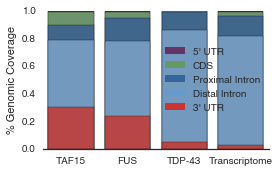

In [26]:
num_cols = 1
num_rows = 1 
with dataviz.Figure(os.path.join(img_dir, "percent_binding.svg"), figsize=(num_cols * 4.0,num_rows * 2.5)) as fig:
    ax = fig.add_subplot(num_rows,num_cols,1)

    sns.barplot(np.array(cumsum_df.columns), y=cumsum_df.ix['five_prime_utrs'], color=region_colors['five_prime_utrs'], ax=ax)
    sns.barplot(np.array(cumsum_df.columns), y=cumsum_df.ix['cds'], color=region_colors['cds'], ax=ax)
    sns.barplot(np.array(cumsum_df.columns), y=cumsum_df.ix['proxintron500'], color=region_colors['proxintron500'], ax=ax)
    sns.barplot(np.array(cumsum_df.columns), y=cumsum_df.ix['distintron500'], color=region_colors['distintron500'], ax=ax)
    sns.barplot(np.array(cumsum_df.columns), y=cumsum_df.ix['three_prime_utrs'], color=region_colors['three_prime_utrs'], ax=ax)
    sns.despine(ax=ax, left=True)

    five_prime_utrs = plt.Rectangle((0,0),1,1, fc=region_colors['five_prime_utrs'], edgecolor = 'none')
    cds = plt.Rectangle((0,0),1,1,fc=region_colors['cds'],  edgecolor = 'none')
    proxintron500 = plt.Rectangle((0,0),1,1, fc=region_colors['proxintron500'], edgecolor = 'none')
    distintron500 = plt.Rectangle((0,0),1,1,fc=region_colors['distintron500'],  edgecolor = 'none')
    three_prime_utrs = plt.Rectangle((0,0),1,1, fc=region_colors['three_prime_utrs'], edgecolor = 'none')

    l = plt.legend([five_prime_utrs, cds, proxintron500, distintron500, three_prime_utrs], 
                   ["5' UTR", 'CDS', 'Proximal Intron', "Distal Intron", "3' UTR"], loc=5, ncol = 1, prop={'size':10})
    l.draw_frame(False)
    #Need to change to percent
    ax.set_ylabel("% Genomic Coverage")

In [10]:
log2_fold_enrichment = np.log2(df.div(df.Transcriptome, axis=0))
log2_fold_enrichment = log2_fold_enrichment.drop("Transcriptome", axis=1)

Figure 2b checks out, but I don't quite want to remake Kasey's nice image right now, leaving it be

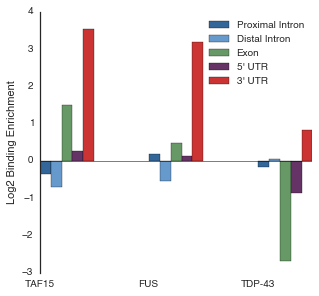

In [25]:
num_rows = 10
num_cols = 10
width=.50
ind = np.arange(len(log2_fold_enrichment.columns))

with dataviz.Figure(os.path.join(img_dir, "differental_expression_plot.svg"), figsize=(4 * num_cols,4*num_rows)) as fig:
    gs = gridspec.GridSpec(num_rows, num_cols)

    ax = fig.add_subplot(gs[0,0])

    ax.bar(ind + ((width / 5) * 0), 
            log2_fold_enrichment.T.proxintron500.values, 
            width / 5, 
            color=region_colors['proxintron500'], 
            label="Proximal Intron",
           )
    
    ax.bar(ind + ((width / 5) * 1), 
            log2_fold_enrichment.T.distintron500.values, 
            width / 5, 
            color=region_colors['distintron500'], 
            label="Distal Intron",
           )
    ax.bar(ind + ((width / 5) * 2), 
            log2_fold_enrichment.T.cds.values, 
            width / 5, 
            color=region_colors['cds'], 
            label="Exon",
           )
    ax.bar(ind + ((width / 5) * 3), 
            log2_fold_enrichment.T.five_prime_utrs.values, 
            width / 5, 
            color=region_colors['five_prime_utrs'], 
            label="5' UTR",
           )
    ax.bar(ind + ((width / 5) * 4), 
            log2_fold_enrichment.T.three_prime_utrs.values, 
            width / 5, 
            color=region_colors['three_prime_utrs'], 
            label="3' UTR",
           )
    
    ax.legend(loc=0)
    sns.despine(ax=ax, bottom=True)
    ax.set_ylabel("Log2 Binding Enrichment")
    ax.axhline(0, color='k', linewidth=.5)
    ax.set_xticks(ind)
    ax.set_xticklabels(log2_fold_enrichment.columns)


#Remake figures C and D

In [12]:
overlapping = defaultdict(dict)
for rbp_1 in rbps:
    for rbp_2 in rbps:
        overlapping[rbp_1][rbp_2] = len(rbps[rbp_1].intersect(rbps[rbp_2], u=True, s=True)) / ( 1.0 * len(rbps[rbp_1]))
        
overlapping_targets = pd.DataFrame(overlapping)

In [13]:
overlapping_targets

,fus,taf15,tdp43
fus,1.000000,0.063417,0.008199
taf15,0.480080,1.000000,0.040133
tdp43,0.185259,0.117383,1.000000


#Unique Targets

In [14]:
overlapping = defaultdict(dict)
for rbp_1 in rbps:
    rbps_copy = rbps.copy()
    del rbps_copy[rbp_1]
    unique_sites = rbps[rbp_1]
    for rbp_2 in rbps_copy:
        unique_sites = unique_sites.intersect(rbps_copy[rbp_2], s=True, v=True)
    print rbp_1, len(unique_sites) / (len(rbps[rbp_1]) * 1.0)
# overlapping_targets = pd.DataFrame(overlapping)

tdp43 0.956864688805
fus 0.451527224436
taf15 0.836621804086


#Venn Diagram of overlapping sites

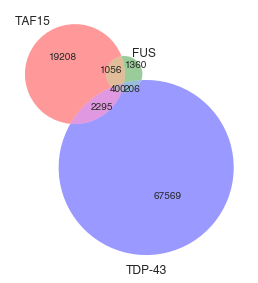

In [23]:
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "overlapping_sites.svg"), figsize=(4 * num_cols,4*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    venn3({"001": len(rbps['tdp43'].intersect(rbps['fus'], s=True, v=True).intersect(rbps['taf15'], s=True, v=True)),
           "010": len(rbps['fus'].intersect(rbps['taf15'], s=True, v=True).intersect(rbps['tdp43'], s=True, v=True)),
           "011": len(rbps['fus'].intersect(rbps['tdp43'], s=True, u=True).intersect(rbps['taf15'], s=True, v=True)),
           "100": len(rbps['taf15'].intersect(rbps['fus'], s=True, v=True).intersect(rbps['tdp43'], s=True, v=True)),
           "101": len(rbps['taf15'].intersect(rbps['fus'], s=True, v=True).intersect(rbps['tdp43'], s=True, u=True)),
           "110": len(rbps['taf15'].intersect(rbps['fus'], s=True, u=True).intersect(rbps['tdp43'], s=True, v=True)),
           "111": len(rbps['taf15'].intersect(rbps['fus'], s=True, u=True).intersect(rbps['tdp43'], s=True, u=True)),
          },
          set_labels=["TAF15", "FUS", "TDP-43"], ax=ax)

#Unique / common targets

In [18]:
overlapping = defaultdict(dict)
for rbp_1 in rbps:
    for rbp_2 in rbps:
        rbp_1_genes = set(interval.name for interval in rbps[rbp_1])
        rbp_2_genes = set(interval.name for interval in rbps[rbp_2])
        overlapping[rbp_1][rbp_2] = len(rbp_1_genes & rbp_2_genes) / (1.0 * len(rbp_1_genes))
overlapping_genes = pd.DataFrame(overlapping)

In [19]:
overlapping_genes

,fus,taf15,tdp43
fus,1.000000,0.219824,0.106722
taf15,0.940622,1.000000,0.402590
tdp43,0.939680,0.828414,1.000000


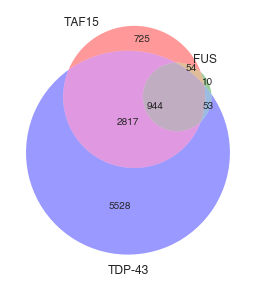

In [24]:
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "overlapping_targets.svg"), figsize=(4 * num_cols,4*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    venn3([set(interval.name for interval in rbps['taf15']),
           set(interval.name for interval in rbps['fus']),
           set(interval.name for interval in rbps['tdp43']),],
         set_labels=["TAF15", "FUS", "TDP-43"], ax=ax)

Numbers are close, but not exactly what I see in Kasey's data, not quite sure why

#Overlap individually processed datsets with combined TAF15

In [27]:
A = pybedtools.BedTool("/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v5/TAF15_1.polyATrim.adapterTrim.rmRep.rmDup.sorted.peaks.kasey.bed")
B = pybedtools.BedTool("/nas3/gpratt/projects/fet_family/analysis/mouse_clip_v5/TAF15_2.polyATrim.adapterTrim.rmRep.rmDup.sorted.peaks.kasey.bed")

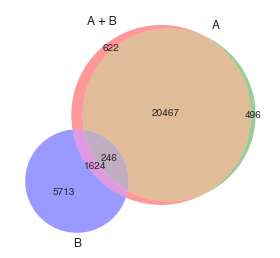

In [29]:
num_rows = 1
num_cols = 1
with dataviz.Figure(os.path.join(img_dir, "overlapping_technical_peaks.svg"), figsize=(4 * num_cols,4*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    
    venn3({"001": len(B.intersect(A, s=True, v=True).intersect(rbps['taf15'], s=True, v=True)),
           "010": len(A.intersect(rbps['taf15'], s=True, v=True).intersect(B, s=True, v=True)),
           "011": len(A.intersect(B, s=True, u=True).intersect(rbps['taf15'], s=True, v=True)),
           "100": len(rbps['taf15'].intersect(A, s=True, v=True).intersect(B, s=True, v=True)),
           "101": len(rbps['taf15'].intersect(A, s=True, v=True).intersect(B, s=True, u=True)),
           "110": len(rbps['taf15'].intersect(A, s=True, u=True).intersect(B, s=True, v=True)),
           "111": len(rbps['taf15'].intersect(A, s=True, u=True).intersect(B, s=True, u=True)),
          },
          set_labels=["A + B", "A", "B"], ax=ax)